In [1]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
import scipy

In [2]:
from openpilot.transformations import get_calib_from_vp, FOCAL_LENGTH, FRAME_SIZE

In [17]:
import generate_labels
from helpers import images, lanes, lines

importlib.reload(generate_labels)
importlib.reload(images)
importlib.reload(generate_labels)
importlib.reload(lanes)
importlib.reload(lines)

get_intersection = lines.get_intersection
generate_and_write_labels = generate_labels.generate_and_write_labels
image_to_vp = generate_labels.image_to_vp
params = generate_labels.params

In [4]:
training_data = np.load('data/training.npy', allow_pickle=True) # shape: [(frame, calibration), ...]
test_data = np.load('data/test.npy', allow_pickle=True) # shape: (frame,)

In [18]:
# Running this block overwrites the generated eval (/eval) labels

vid_0 = ('eval/0.txt', training_data[:1200])
vid_1 = ('eval/1.txt', training_data[1200:2400])
vid_2 = ('eval/2.txt', training_data[2400:3600])
vid_3 = ('eval/3.txt', training_data[3600:4800])
vid_4 = ('eval/4.txt', training_data[4800:])
eval_videos = [vid_0, vid_1, vid_2, vid_3, vid_4]

for eval_video in eval_videos:
    filename, frames = eval_video
    generate_and_write_labels(filename, frames)

{'x_bottom_offset': 50, 'x_top_offset': 300, 'y_bottom_offset': 150, 'y_top_offset': -10}


In [9]:
# Running this block overwrites the generated test (/test) labels

vid_5 = ('unlabeled/5.txt', test_data[:1200])
vid_6 = ('unlabeled/6.txt', test_data[1200:2400])
vid_7 = ('unlabeled/7.txt', test_data[2400:3600])
vid_8 = ('unlabeled/8.txt', test_data[3600:4800])
vid_9 = ('unlabeled/9.txt', test_data[4800:])
test_videos = [vid_5, vid_6, vid_7, vid_8, vid_9]

for test_video in test_videos:
    filename, frames = test_video
    generate_and_write_labels(filename, frames)

In [20]:
# Load in the generated eval labels
eval_videos = []
for i in range(5):
    video = pd.read_csv(f'eval/{i}.txt', names = ['pitch', 'yaw'], delim_whitespace=True)
    eval_videos.append(video)

eval_labels = pd.concat(eval_videos, ignore_index=True)

(5996, 2)


In [21]:
# Load in the generated training labels
train_videos = []
for i in range(5):
    video = pd.read_csv(f'labeled/{i}.txt', names = ['pitch', 'yaw'], delim_whitespace=True)
    train_videos.append(video)

train_labels = pd.concat(train_videos, ignore_index=True)

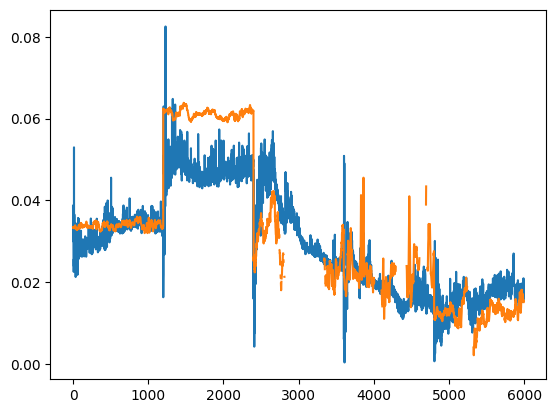

In [22]:
# training / eval pitch comparison
plt.plot(eval_labels.index, eval_labels['pitch'], label='pitch-eval')
plt.plot(train_labels.index, train_labels['pitch'], label='pitch-train')

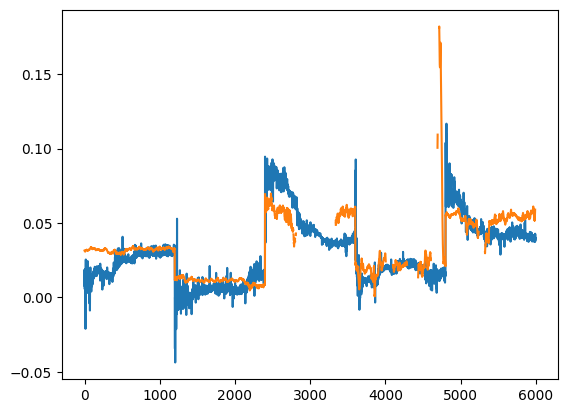

In [23]:
# training / eval yaw comparison
plt.plot(eval_labels.index, eval_labels['yaw'], label='yaw-eval')
plt.plot(train_labels.index, train_labels['yaw'], label='yaw-train')

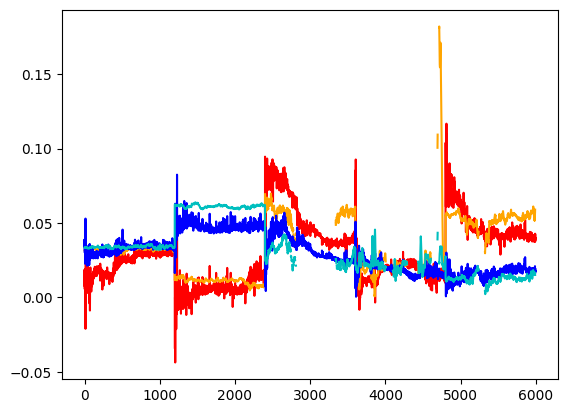

In [24]:
x = eval_labels.index

plt.plot(x, eval_labels['yaw'], label='yaw-eval', color='red')
plt.plot(x, train_labels['yaw'], label='yaw-train', color='orange')
plt.plot(x, eval_labels['pitch'], label='pitch-eval', color='b')
plt.plot(x, train_labels['pitch'], label='pitch-train', color='c')

In [27]:
# Load in the generated test labels
test_videos = []
for i in range(5, 10):
    video = pd.read_csv(f'unlabeled/{i}.txt', names = ['pitch', 'yaw'], delim_whitespace=True)
    test_videos.append(video)

test_labels = pd.concat(test_videos, ignore_index=True)

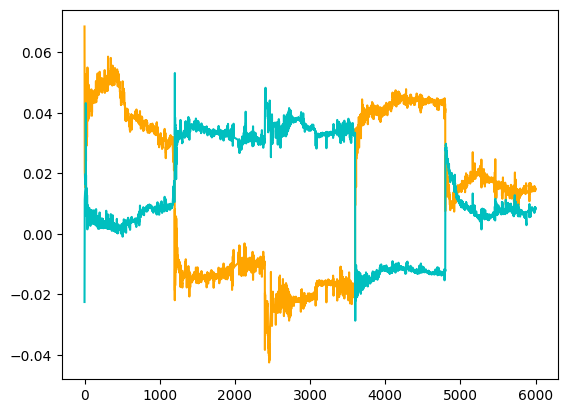

In [16]:
# Sense checking the test labels

plt.plot(test_labels.index, test_labels['yaw'], label='yaw-test', color='orange')
plt.plot(test_labels.index, test_labels['pitch'], label='pitch-test', color='c')

Variation high between videos and relatively lower within videos, which is expected. I used filtering that should generalize well and had 13.07% MSE on the labeled videos, so I'm comfortable submitting this.

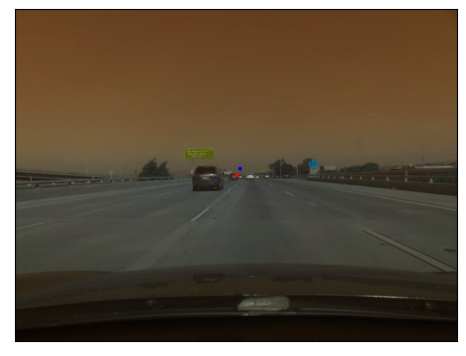

In [18]:
# Edited standard lines to roughly match perfect camera mounting

intersection = get_intersection(params['standard_right_lane'], params['standard_left_lane']) 
test_vp = np.array([int(FRAME_SIZE[0]/2), int(FRAME_SIZE[1]/2)]) # center of the image

im_copy = np.copy(test_data[100])
cv2.circle(im_copy, (int(intersection[0]), int(intersection[1])), 5, (0, 0, 255), -1) # standard lanes vp
cv2.circle(im_copy, (int(test_vp[0]), int(test_vp[1])), 5, (255, 0, 0), -1) # center of image
images.show([im_copy])

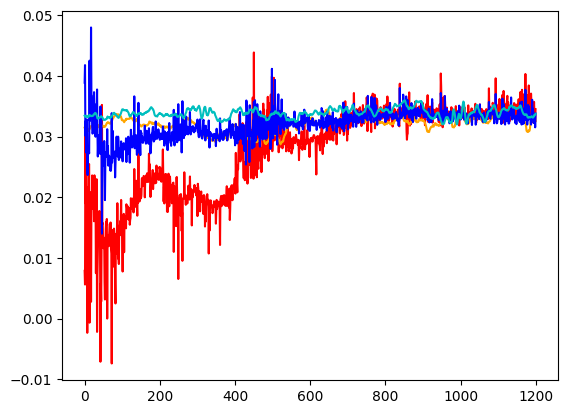

In [15]:
# Sandbox for testing variations of params on portions of the data

calculated_vps = []
left_lanes = []
right_lanes = []
scale = []

count = 1200
start_idx = 0
training_slice = training_data[start_idx:count+start_idx]
for frame in training_slice:
    current_img = np.copy(frame)
    vp = image_to_vp(current_img, left_lanes, right_lanes)
    _roll_calib, pitch_calib, yaw_calib = get_calib_from_vp(vp)
    calculated_vps.append([pitch_calib, yaw_calib])

train_yaw_labels = [x for x in train_labels['yaw'][start_idx:count+start_idx]]
eval_yaw_labels = [yaw for pitch, yaw in calculated_vps]

train_pitch_labels = [x for x in train_labels['pitch'][:count]]
eval_pitch_labels = [pitch for pitch, yaw in calculated_vps]


plt.plot(range(count), eval_yaw_labels, label='yaw-eval', color='red')
plt.plot(range(count), train_yaw_labels, label='yaw-train', color='orange')
plt.plot(range(count), eval_pitch_labels, label='pitch-eval', color='b')
plt.plot(range(count), train_pitch_labels, label='pitch-train', color='c')

In [10]:
training_slice = np.concatenate([training_data[:300], training_data[1200:1500], training_data[2400:2700], training_data[3600:3900], training_data[4800:5100]])

In [13]:
training_slice_labels = pd.concat([train_labels[:300], train_labels[1200:1500], train_labels[2400:2700], train_labels[3600:3900], train_labels[4800:5100]], ignore_index=True)

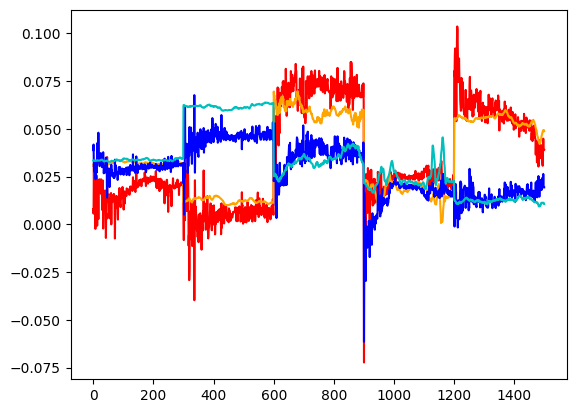

In [14]:
# Sandbox for testing variations of params on portions of the data

calculated_vps = []
left_lanes = []
right_lanes = []
scale = []
count = 0
for frame in training_slice:
    if count % 300 == 0:
        left_lanes = []
        right_lanes = []
    count += 1
    current_img = np.copy(frame)
    vp = image_to_vp(current_img, left_lanes, right_lanes)
    _roll_calib, pitch_calib, yaw_calib = get_calib_from_vp(vp)
    calculated_vps.append([pitch_calib, yaw_calib])

train_yaw_labels = [x for x in training_slice_labels['yaw']]
eval_yaw_labels = [yaw for pitch, yaw in calculated_vps]

train_pitch_labels = [x for x in training_slice_labels['pitch']]
eval_pitch_labels = [pitch for pitch, yaw in calculated_vps]


plt.plot(training_slice_labels.index, eval_yaw_labels, label='yaw-eval', color='red')
plt.plot(training_slice_labels.index, train_yaw_labels, label='yaw-train', color='orange')
plt.plot(training_slice_labels.index, eval_pitch_labels, label='pitch-eval', color='b')
plt.plot(training_slice_labels.index, train_pitch_labels, label='pitch-train', color='c')

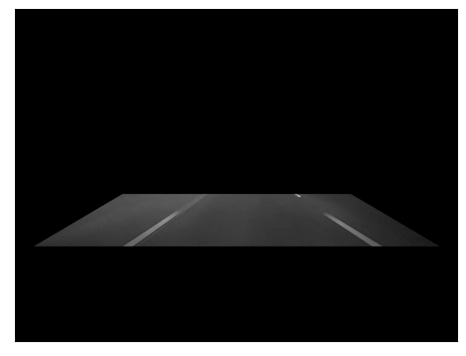

<function get_roi_from_img at 0x169a71090>


In [6]:
rand_idx = np.random.randint(0, len(training_data))
img = cv2.cvtColor(np.copy(training_data[rand_idx]), cv2.COLOR_BGR2GRAY)
mask = np.zeros_like(img)
ignore_mask_color = 255
y, x = img.shape
y_offset = 50
x_offset = 300
roi = {'x_bottom_offset': 50,
        'x_top_offset': 300,
        'y_bottom_offset': 250,
        'y_top_offset': 50,
        }

roi_vertices = np.array([[(roi['x_bottom_offset'], y - roi['y_bottom_offset']),
                              (x / 2 - roi['x_top_offset'], y / 2 + roi['y_top_offset']),
                              (x / 2 + roi['x_top_offset'], y / 2 + roi['y_top_offset']),
                              (x - roi['x_bottom_offset'], y - roi['y_bottom_offset'])]],
                              dtype=np.int32)

cv2.fillPoly(mask, roi_vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(img, img, mask=mask)
images.show([masked_edges])
print(images.get_roi_from_img)